# ENCODE bigWig analysis questions

Do your best to answer all parts of each question. You are encouraged to collaborate, but should turn in your own answers. 

Please limit each answer to a maximum of one markdown cell, one code cell and one plot. 

Put helper functions into a separate script (e.g. `hwutils.py`) so the notebook can be focused on plotting. Also see the [workshop on Clean Code](https://drive.google.com/file/d/1TraVwRkbkCbHq-s_-NS69ZEbRNwH8XNh/view) from Dan Larremore (https://larremorelab.github.io/slides/) for good coding tips to use in this assignment.


In [ ]:
I worked with Allen and Qifan. 

In [73]:
# useful libraries to import

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import manifold

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b') 
# nice way to format ticks as human-readable: ax.xaxis.set_major_formatter(bp_formatter)

from hwutils import *

import textwrap

from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# load dataFrame of bigWigs from ENCODE (encodeproject.org/), binned to 10kb resolution across chromosome 10.
# note that the first three columns are chrom,start,end and the other columns are labeled by bigWig file accession.
df = pd.read_table('ENCODE_GRCh38_binned_subset.tsv')

# load metadata from ENCODE for bigwig files. 
# can be queried as follows: bigwig_metadata.query("`File accession`==@ df_column_name ")
bigwig_metadata = pd.read_table('ENCODE_GRCh38_bigWig_metadata.tsv')

C:\Users\marca\AppData\Local\Temp\ipykernel_46268\1843482741.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  bigwig_metadata = pd.read_table('ENCODE_GRCh38_bigWig_metadata.tsv')


- After loading the data (above), and visualize some of the profiles. Why might many signals dip on chr10 at around 40Mb?


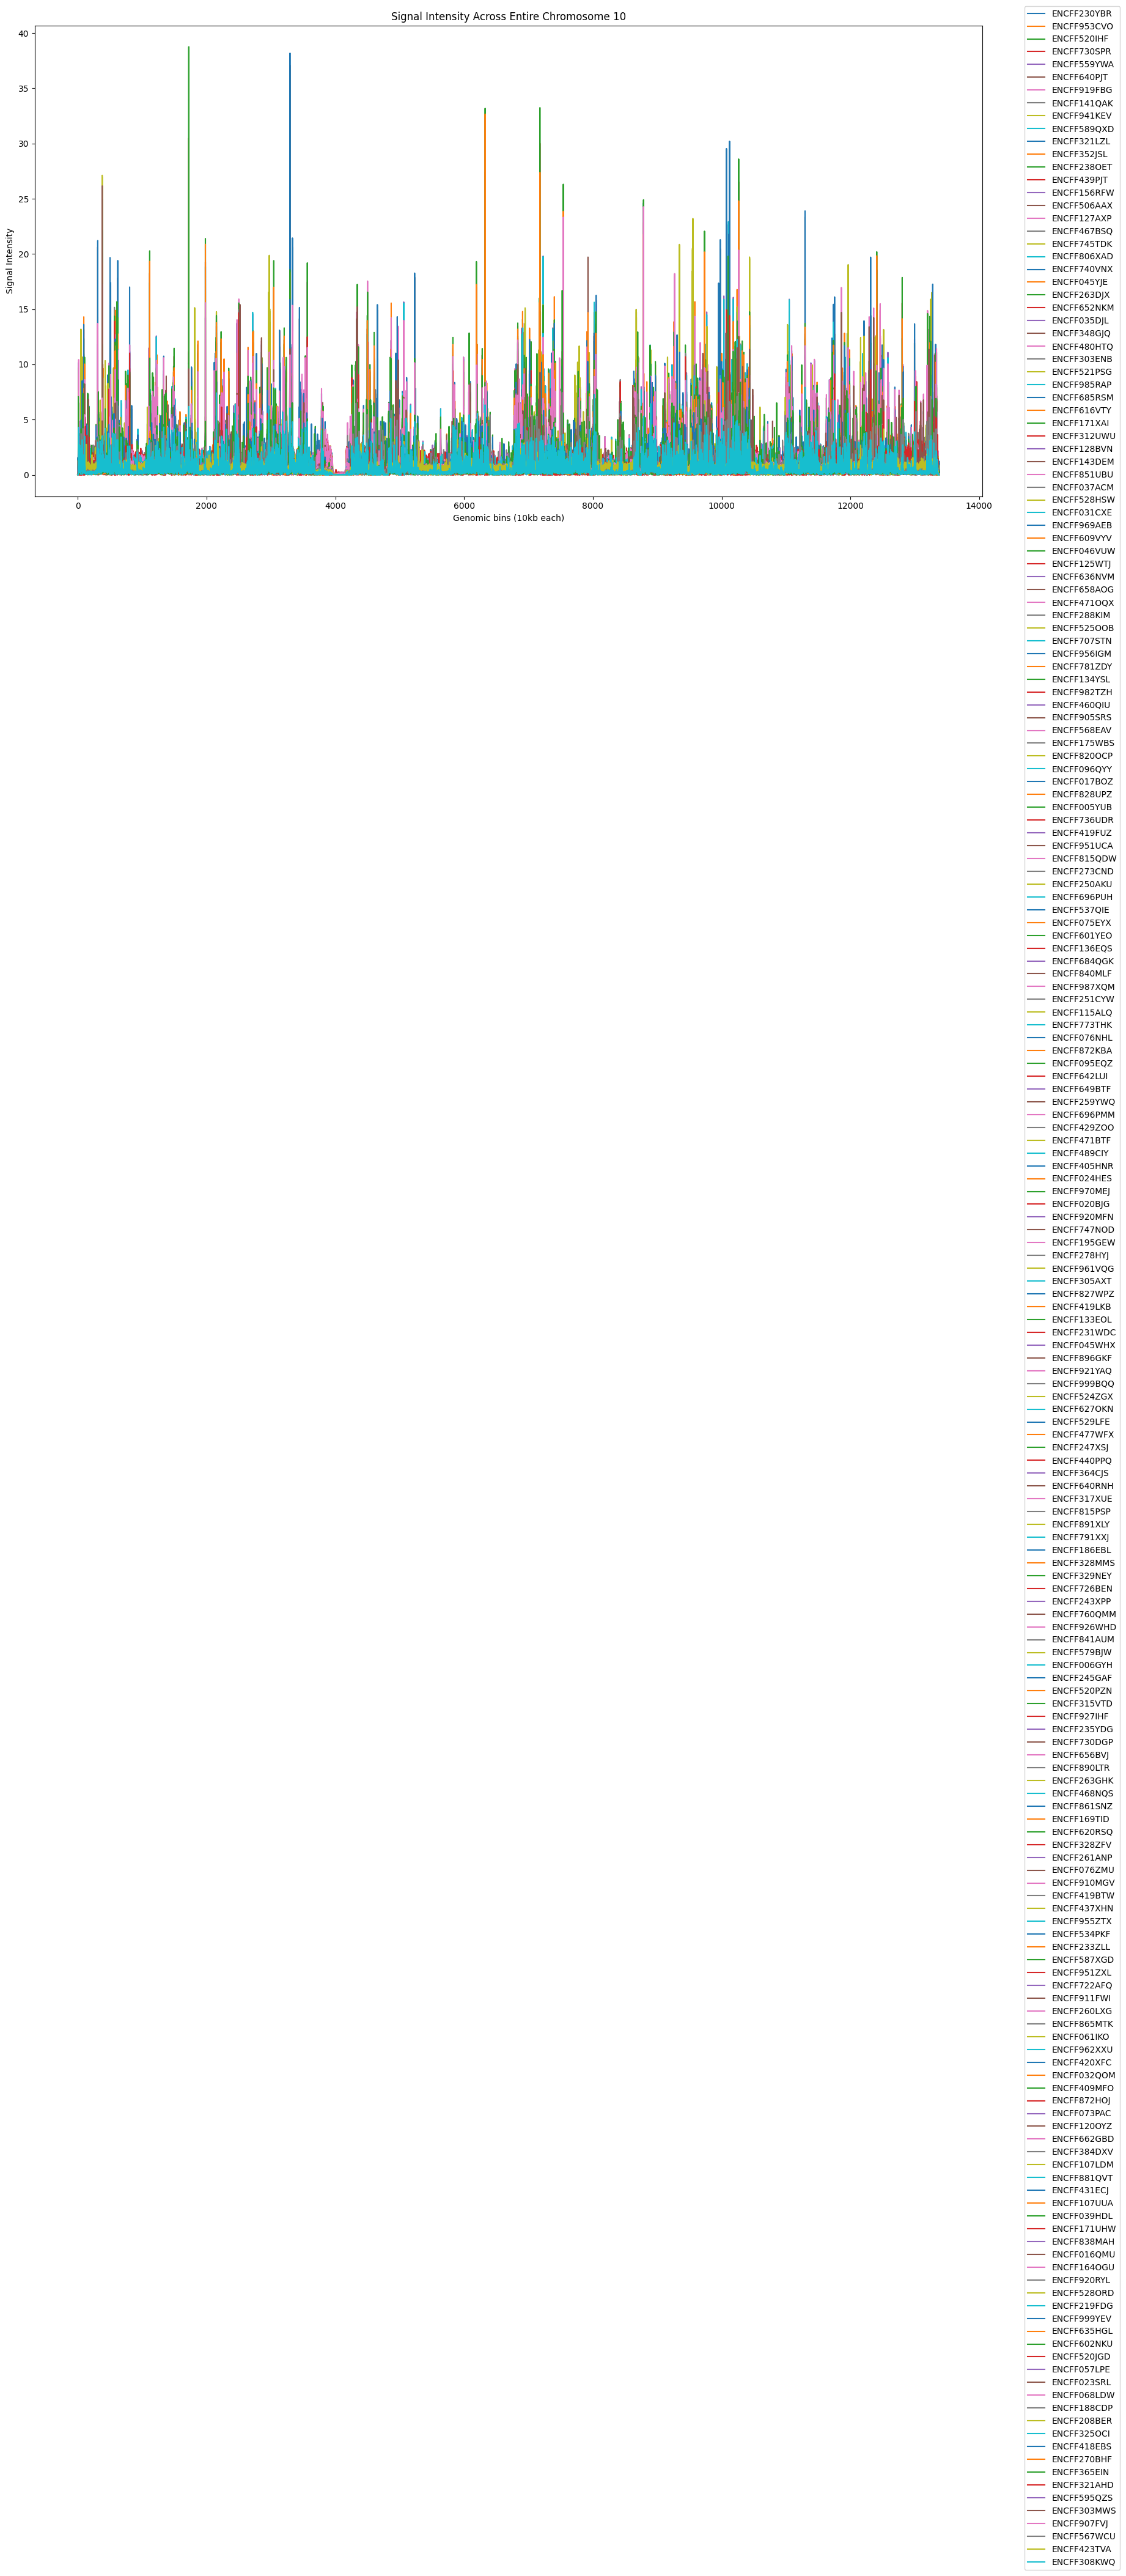

In [3]:
# Drop the first three columns ('chrom', 'start', 'end') as they're not signal values
df_signals = df.drop(columns=df.columns[0:3])

# Convert all data to numeric, as the signal intensity values are numeric
df_signals = df_signals.apply(pd.to_numeric, errors='coerce')

# Plot all signals
plt.figure(figsize=(20, 10))

for column in df_signals.columns:
    plt.plot(df_signals.index, df_signals[column], label=column)

plt.xlabel('Genomic bins (10kb each)')
plt.ylabel('Signal Intensity')
plt.title('Signal Intensity Across Entire Chromosome 10')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
plt.show()

In regions where the DNA sequence is highly repetitive, such as centromeres, the mappability is often low because it is difficult to determine the exact origin of a short sequence read within these repetitive stretches. This is because many locations along the sequence may have an identical or very similar sequence, leading to ambiguity in alignment. In the context of genomic assays, such as ChIP-seq, DNase-seq, or any sequencing-based method, low mappability around centromeres will typically result in fewer uniquely aligned reads. Consequently, this manifests as a dip in the signal intensity because fewer reads can be confidently assigned to that region. The tools that process sequencing data often discard reads that do not map uniquely to the reference genome to avoid erroneous interpretations of the data.

- Use scikit-learn to perform PCA, and make a scatterplot of PC1 vs PC2.


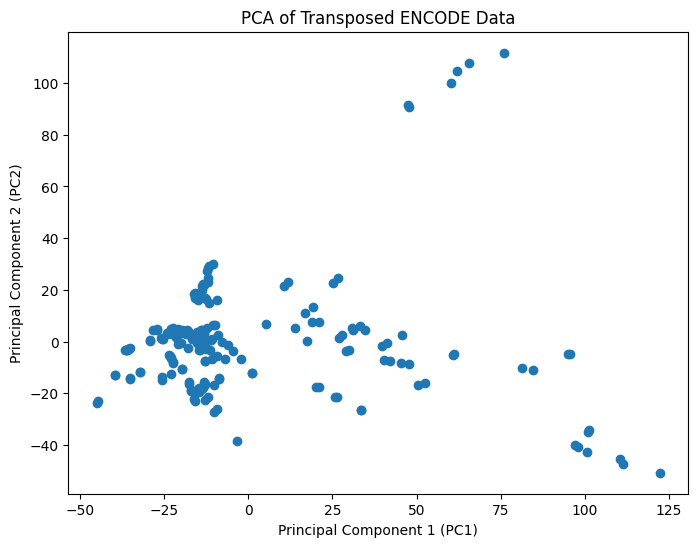

In [61]:
# Drop the first three columns ('chrom', 'start', 'end') as they're not signal values
df_signals = df.drop(columns=df.columns[:3])
df_signals = df_signals.apply(pd.to_numeric, errors='coerce')

# Transpose the data so that rows are samples and columns are features
df_signals_transposed = df_signals.T

# Perform PCA on the transposed data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_signals_transposed)

# Create a DataFrame with the principal components
df_principal = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Scatter plot of PC1 vs PC2
plt.figure(figsize=(8, 6))
plt.scatter(df_principal['PC1'], df_principal['PC2'])
plt.title('PCA of Transposed ENCODE Data')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()


- Try to use the experiment metadata to understand and remove outliers. Try labeling or coloring points by various metadata columns. Were any columns in the metadata useful for outlier removal? Note that `sklearn.preprocessing.LabelEncoder()` can be useful for transforming text strings to categories, and `plt.text` can be used to overlay labels with points.

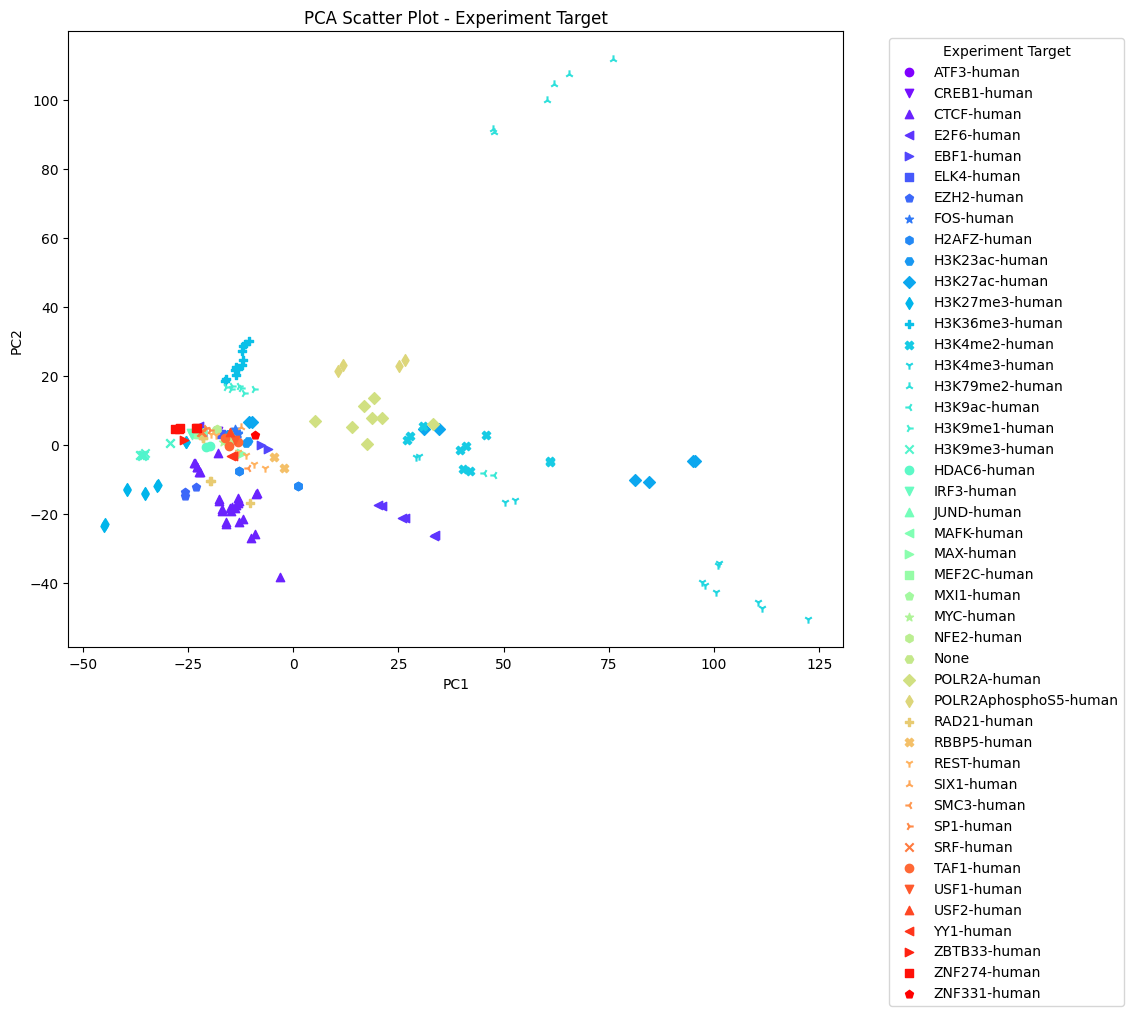

C:\Users\marca\AppData\Local\Temp\ipykernel_46268\1711606734.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_audit_errors))


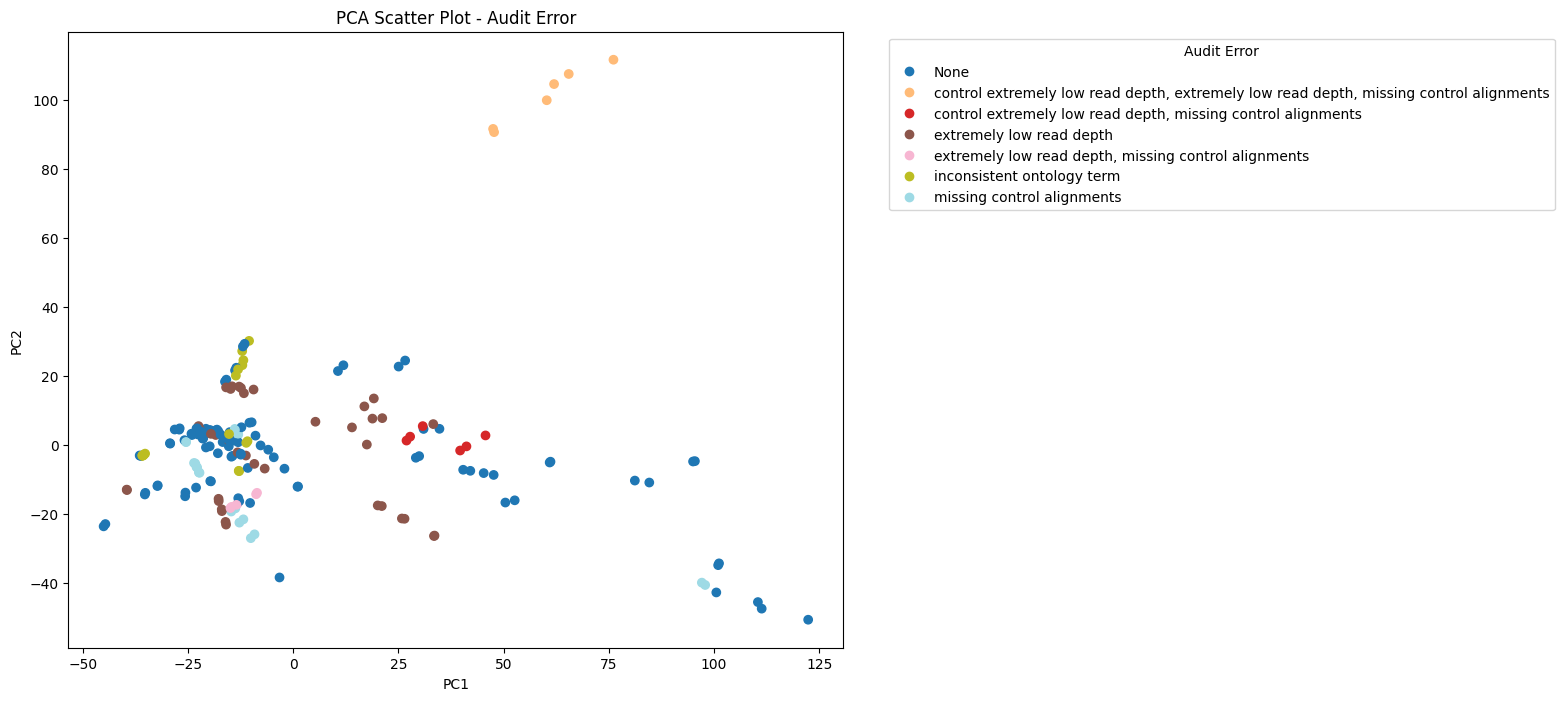

In [72]:


# Helper function to find labels
def find(col, bigwig_metadata, profiles):
    labels = []
    for profile in profiles:
        value = bigwig_metadata.query("`File accession` == @profile")[col].values
        labels.append(value[0] if len(value) > 0 else 'nan')  # Add 'nan' if not found
    le = LabelEncoder()
    le.fit(labels)
    return le, labels

# Get the profiles from the columns of the original dataframe
profiles = df.columns[3:]

# Get the labels for 'Experiment Target'
le_experiment_target, labels_experiment_target = find('Experiment target', bigwig_metadata, profiles)

# Create a DataFrame for the PCA results with the encoded labels
df_pca = pd.DataFrame({
    'PC1': df_signals_pca[:, 0],
    'PC2': df_signals_pca[:, 1],
    'Experiment Target': le_experiment_target.transform(labels_experiment_target)
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Define markers and colors
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '1', '2', '3', '4', 'x']
colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(df_pca['Experiment Target']))))

# Wrap long labels for better display
wrapper = textwrap.TextWrapper(width=30)
wrapped_labels = [wrapper.fill(text) for text in le_experiment_target.classes_]

# Plot each experiment target with unique color and marker
for i, target in enumerate(np.unique(df_pca['Experiment Target'])):
    indices = df_pca['Experiment Target'] == target
    marker = markers[i % len(markers)]
    ax.scatter(df_pca.loc[indices, 'PC1'], df_pca.loc[indices, 'PC2'], 
               label=wrapped_labels[i], marker=marker, color=colors[i])

# Add legend outside the plot
ax.legend(title='Experiment Target', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Scatter Plot - Experiment Target')

plt.show()

# Find labels for 'Audit Error'
le_audit_error, labels_audit_error = find('Audit ERROR', bigwig_metadata, df.columns[3:])

# Add 'nan' as a category for missing values if it's not already present
if 'nan' not in le_audit_error.classes_:
    le_audit_error.classes_ = np.append(le_audit_error.classes_, 'nan')

# Assign an integer to 'nan' labels
labels_audit_error_encoded = np.where(np.array(labels_audit_error) == 'nan', 
                                      len(le_audit_error.classes_) - 1, 
                                      le_audit_error.transform(labels_audit_error))

# Create a color map based on unique audit error categories
unique_audit_errors = np.unique(labels_audit_error_encoded)
colors = plt.cm.get_cmap('tab20', len(unique_audit_errors))

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame({
    'PC1': df_signals_pca[:, 0],
    'PC2': df_signals_pca[:, 1],
    'Audit ERROR': labels_audit_error_encoded
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot colored by audit error
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Audit ERROR'], cmap=colors)

# Create a legend
legend_labels = {index: label for index, label in enumerate(le_audit_error.classes_)}
handles, _ = scatter.legend_elements(prop='colors', num=len(unique_audit_errors))
legend = ax.legend(handles, [legend_labels[i] for i in unique_audit_errors], title='Audit Error', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set axis labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Scatter Plot - Audit Error')

plt.show()

In 'Experiment Target' H3K79me2 seems to be outliers, far from the other data points. In 'Audit ERROR', control extremely low depth, extremely low read depth, missing control alignment data points seems to be far from the other data points, which makes sense. 

- Which Assays or Experiment Targets show broad vs narrow patterns? Is this consistent across cell types? Does this relate to the patterns seen in PCA? One way to investigate the characteristic scale is by computing the autocorrelation.


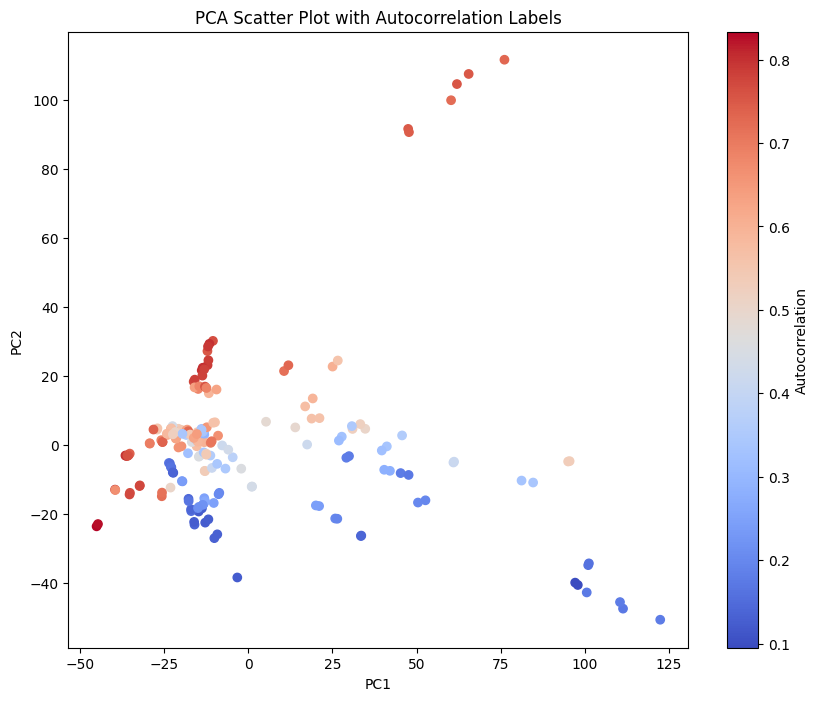

In [71]:
# Helper function to calculate autocorrelation
def calculate_autocorrelation(profile):
    # The 'acf' function from statsmodels can compute autocorrelation
    autocorr = acf(profile, nlags=1)[1]  # Getting the lag-1 autocorrelation
    return autocorr

# Calculate the autocorrelation for each profile
df_signals['Autocorrelation'] = df_signals.apply(calculate_autocorrelation, axis=1)

# Map the autocorrelation values to the PCA points
df_pca['Autocorrelation'] = df_signals['Autocorrelation'].values  # Assumes same ordering

# Plotting the PCA points with labels for autocorrelation
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the PCA points
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Autocorrelation'], cmap='coolwarm')

# Add a color bar to the scatter plot to show the autocorrelation values
colorbar = plt.colorbar(scatter)
colorbar.set_label('Autocorrelation')

# Show the plot
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot with Autocorrelation Labels')
plt.show()


- For Experiment Targets: H3K27-me3 seems to have high autocorrelation. CTCF and H3K27ac seems to have low autocorrelation. 

- Which "Experiment Targets" (e.g. histone marks or transcription factors) for which cell types are nearby in this PC1 vs PC2 space? Do any of these proximities have plausible biological interpretations? For example, are any polycomb-related factors in proximity? Illustrate this in a plot.


In [ ]:
- EZH2-human: EZH2 is a well-known component of the Polycomb Repressive Complex 2 (PRC2) and acts as a histone methyltransferase that specifically targets histone H3 on lysine 27 (H3K27me3), leading to transcriptional repression.
- H3K27me3-human: This is a histone modification that is directly linked to Polycomb-mediated gene repression. H3K27me3 is established by PRC2 and is a hallmark of Polycomb-silenced genes.
These are both polycomb factors, EZH2 is a pentagon and  H3K27me3 is a diamond. Both EZH2 and H3K27me3 are involved in the repression of gene expression. Their closeness on the PCA plot indicates that samples with high levels of gene repression cluster together.

- How much does preprocessing matter? Try normalizing the variance per track and see if you arrive at similar or distinct conclusions. Try removing the region on chr10 mentioned above. Note that `sklearn.preprocessing.StandardScaler` could be useful for preprocessing. 


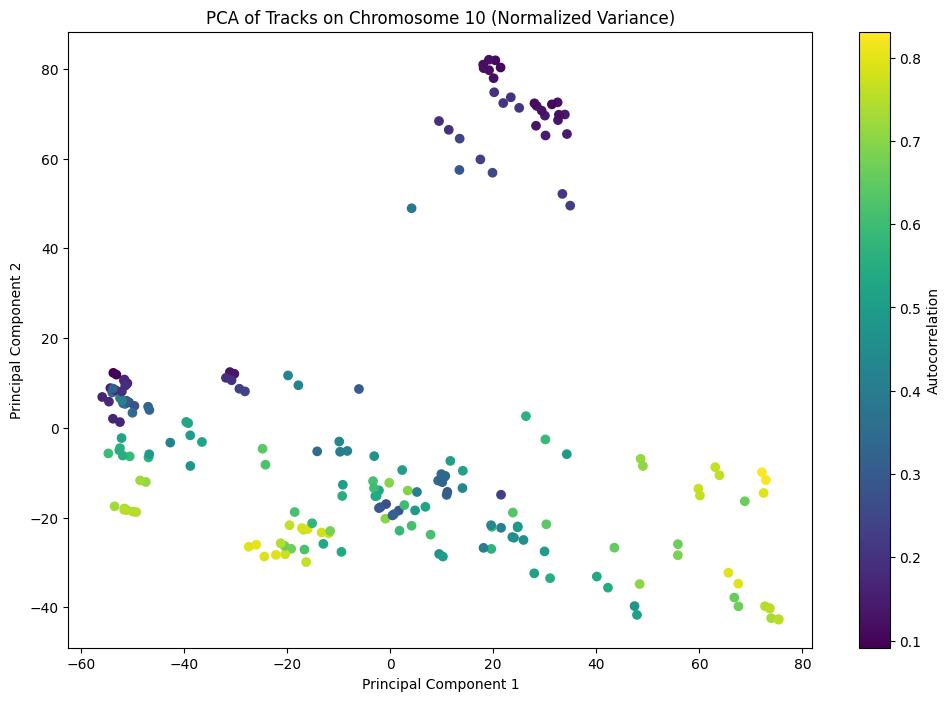

In [68]:
# Define the region to be removed from the chromosome
region_start = 40000000
region_end = 41500000
df_clean = df[(df['start'] < region_start) | (df['end'] > region_end)]

# Isolate the bigWig track data for scaling
tracks = df_clean.columns[3:]
df_tracks = df_clean[tracks]

# Normalize each track (feature scaling)
scaler = StandardScaler()
scaled_tracks = scaler.fit_transform(df_tracks)

# Transpose the scaled data for PCA
# In sklearn, rows are samples, and columns are features
scaled_tracks_t = scaled_tracks.T

# Perform PCA on the transposed scaled data
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(scaled_tracks_t)

# Calculate autocorrelation for each track using the acf function
autocorrelation_values = np.array([acf(track, nlags=1)[1] for track in scaled_tracks_t])

# Generate a PCA scatter plot, colored by autocorrelation values
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=autocorrelation_values, cmap='viridis')
plt.colorbar(scatter, label='Autocorrelation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Tracks on Chromosome 10 (Normalized Variance)')

# Save the plot if needed
# plt.savefig('PCA_Chromosome10.png')

plt.show()


Preprocessing often involves scaling the variance of each feature to have a unit variance. This means that in the preprocessed data, no single feature will dominate the PCA due to its scale.  Preprocessing can also filter out noise, leading to clearer patterns of intrinsic data structure. In the first PCA plot, the outliers seem to have high autocorrelation. In the preprocessed plot, the outliers seem to have lower autocorrelation. 

- How many PCs are needed to explain 90% of the variance in the data? Illustrate this with a scree plot (https://en.wikipedia.org/wiki/Scree_plot). 


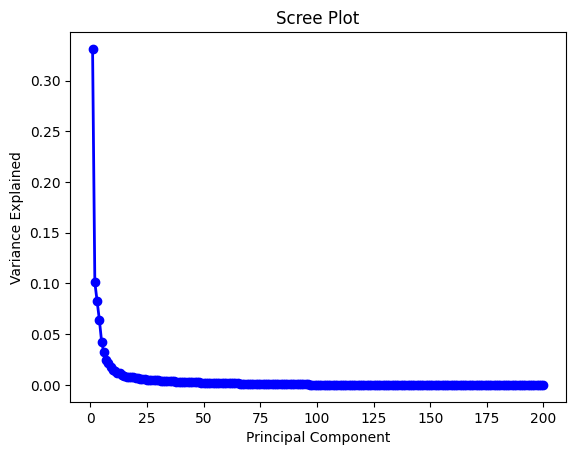

Number of components needed to explain at least 90% of the variance: 36


In [70]:
# Remove the first three columns which are not features
df_features = df.iloc[:, 3:]

# Standardize the features before performing PCA
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

# Perform PCA
pca = PCA()
pca_fit = pca.fit(scaled_df)

# Scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain at least 90% of the variance
num_components = np.where(cumulative_explained_variance >= 0.9)[0][0] + 1

print(f"Number of components needed to explain at least 90% of the variance: {num_components}")


- How different is the dimensionality reduction into two dimensions for PCA from that obtained using MDS (multi-dimensional scaling)? What methods could be used to determine the similarity? Illustrate with a plot.


MDS is non linear, and does not assume linearity for variables. PCA is linear, it assumes linear relationship between variables.

- Would non-negative matrix factorization (https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) be a useful method to use for this dataset? Why or why not?  (No plots needed for this question).


NMF can be used for clustering the data, which is relevant in genomics to identify groups of genes or genomic regions with similar patterns of expression. NMF is particularly suited for datasets where the values are non-negative.